In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    ROOT_DIR = '/content/drive/MyDrive/image_dehazing_major_8th_sem/'
    platform = 'Google Colab'

except:
    ROOT_DIR = ''
    platform = 'Local machine'

dataset_path = f'{ROOT_DIR}Datasets/RESIDE-6K/train'
test_dataset_path = f'{ROOT_DIR}Datasets/RESIDE-6K/test'
model_save_path = f'{ROOT_DIR}models'
result_save_path = f'{ROOT_DIR}results'
plot_save_path = f'{ROOT_DIR}plots'
infer_during_training_path = f'{ROOT_DIR}infer-during-training-pics'

print(f'Platform: {platform}')
dataset_path, test_dataset_path, model_save_path, result_save_path, plot_save_path, infer_during_training_path

Platform: Local machine


('Datasets/RESIDE-6K/train',
 'Datasets/RESIDE-6K/test',
 'models',
 'results',
 'plots',
 'infer-during-training-pics')

In [2]:
try:
    import torchmetrics
    print('TorchMetrics already installed.')
    
except:
    !pip install torchmetrics
    print('TorchMetrics installed.')


TorchMetrics already installed.


In [3]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

from PIL import Image
import os
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import random

from tqdm.auto import tqdm

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [5]:
BATCH_SIZE = 16 if platform == 'Google Colab' else 4
TEST_BATCH_SIZE = 1
LR = 0.001
EPOCHS = 6
WANNA_TRAIN = False
WANNA_TEST = False
WANNA_SAVE = False
INFER_DURING_TRAINING = True

SAVE_PLOT_AS_PDF = False

USE_PARTIALLY_TRAINED = True
state_dict_name = 'LightClearNet_2024-04-11_15-52-13_5epochs.pth'

In [6]:
class NormalizeTensor:
    def __call__(self, tensor):
        return tensor.clamp(-1, 1) * 0.5 + 0.5
    
normalize_tensor = NormalizeTensor()

img_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

tensor_to_img = transforms.Compose([
    transforms.ToPILImage()
])

In [7]:
criterion = nn.L1Loss()
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

def visualize_pair(image1, image2, gap=20):
    image1 = tensor_to_img(image1) if isinstance(image1, torch.Tensor) else image1
    image2 = tensor_to_img(image2) if isinstance(image2, torch.Tensor) else image2

    new_image = Image.new('RGB', (image1.width + gap + image2.width, max(image1.height, image2.height)), color='black')
    new_image.paste(image1, (0, 0))
    new_image.paste(image2, (image1.width + gap, 0))

    return new_image

def visualize_random_pair_target(dataset):
    random_idx = random.randrange(len(dataset))
    print(f'Index: {random_idx}')

    return dataset.visualize_pair(random_idx)

def visualize_random_pair_pred(dataset, model, visualize_target=False, normalize=False):
    random_idx = random.randrange(len(dataset))
    print(dataset.inputs_folder + '/' + dataset.inputs_file_list[random_idx])

    input, target = [tensor.unsqueeze(0) for tensor in dataset[random_idx]]
    print(f'Image size: {[*input.shape]}')

    model.eval()
    with torch.inference_mode():
        pred = model(input)
    if normalize:
        pred = normalize_tensor(pred)

    loss = criterion(pred, target).item()
    psnr = psnr_metric(pred, target).item()
    ssim = ssim_metric(pred, target).item()

    print(f'L1 Loss: {loss:.4f} | PSNR: {psnr:.4f} | SSIM: {ssim * 100:.2f}%')

    if visualize_target:
        return visualize_pair(visualize_pair(input.squeeze(), pred.squeeze()), target.squeeze())
    return visualize_pair(input.squeeze(), pred.squeeze())

In [8]:
class HazyToClearDataset(Dataset):
    def __init__(self, root_loc, transform=None):
        self.root_loc = root_loc
        self.transform = transform

        self.inputs_folder = f'{self.root_loc}/hazy'
        self.targets_folder = f'{self.root_loc}/GT'
        self.inputs_file_list = sorted(os.listdir(self.inputs_folder))
        self.targets_file_list = sorted(os.listdir(self.targets_folder))

    def __len__(self):
        return len(self.inputs_file_list)

    def __getitem__(self, idx):
        input_loc = os.path.join(self.inputs_folder, self.inputs_file_list[idx])
        target_loc = os.path.join(self.targets_folder, self.targets_file_list[idx])

        input = Image.open(input_loc)
        target = Image.open(target_loc)

        if self.transform:
            input = self.transform(input).to(device)
            target = self.transform(target).to(device)

        return input, target

    def visualize_pair(self, idx):
        print(f'Input Image: {self.inputs_folder}/{self.inputs_file_list[idx]}')
        print(f'Target Image: {self.targets_folder}/{self.targets_file_list[idx]}')

        return visualize_pair(*self[idx])
    
    def index(self, image_name):
        return self.inputs_file_list.index(image_name)

In [9]:
dataset = HazyToClearDataset(dataset_path, transform=img_to_tensor)

iset = set(dataset.inputs_file_list)
tset = set(dataset.targets_file_list)

print((iset - tset, tset - iset))

len(dataset), random.choice(dataset)

(set(), set())


(6000,
 (tensor([[[0.5059, 0.4745, 0.2627,  ..., 0.6706, 0.5647, 0.6627],
           [0.4745, 0.3098, 0.2157,  ..., 0.5294, 0.5176, 0.5765],
           [0.4549, 0.2667, 0.2039,  ..., 0.3333, 0.4235, 0.5804],
           ...,
           [0.1216, 0.1216, 0.1255,  ..., 0.1451, 0.1569, 0.1529],
           [0.1216, 0.1216, 0.1255,  ..., 0.1451, 0.1451, 0.1529],
           [0.1176, 0.1255, 0.1294,  ..., 0.1451, 0.1608, 0.1608]],
  
          [[0.6235, 0.5922, 0.3686,  ..., 0.7059, 0.6000, 0.7020],
           [0.5882, 0.4196, 0.3216,  ..., 0.5647, 0.5569, 0.6157],
           [0.5569, 0.3725, 0.3059,  ..., 0.3647, 0.4627, 0.6196],
           ...,
           [0.1216, 0.1216, 0.1255,  ..., 0.1804, 0.1804, 0.1765],
           [0.1216, 0.1216, 0.1255,  ..., 0.1804, 0.1804, 0.1765],
           [0.1176, 0.1255, 0.1294,  ..., 0.1804, 0.1843, 0.1843]],
  
          [[0.7176, 0.7020, 0.4863,  ..., 0.7412, 0.6353, 0.7373],
           [0.6588, 0.5137, 0.4353,  ..., 0.6000, 0.5922, 0.6549],
           [0.6

Index: 1191
Input Image: Datasets/RESIDE-6K/train/hazy/2070.jpg
Target Image: Datasets/RESIDE-6K/train/GT/2070.jpg


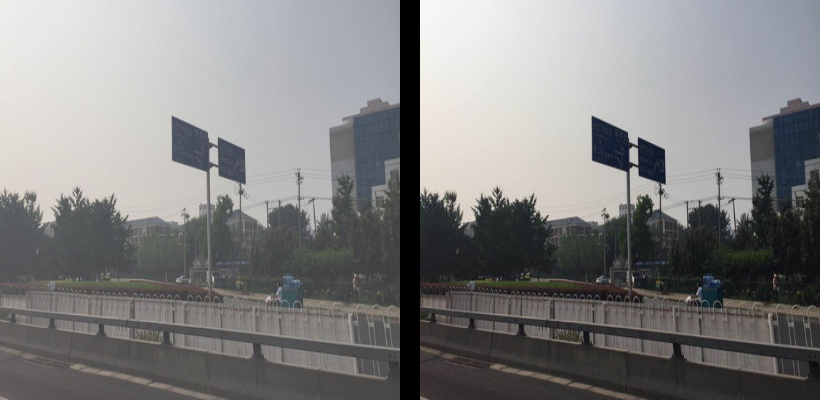

In [10]:
visualize_random_pair_target(dataset)

Input Image: Datasets/RESIDE-6K/train/hazy/1233.jpg
Target Image: Datasets/RESIDE-6K/train/GT/1233.jpg


Input Image: Datasets/RESIDE-6K/train/hazy/1503.jpg
Target Image: Datasets/RESIDE-6K/train/GT/1503.jpg


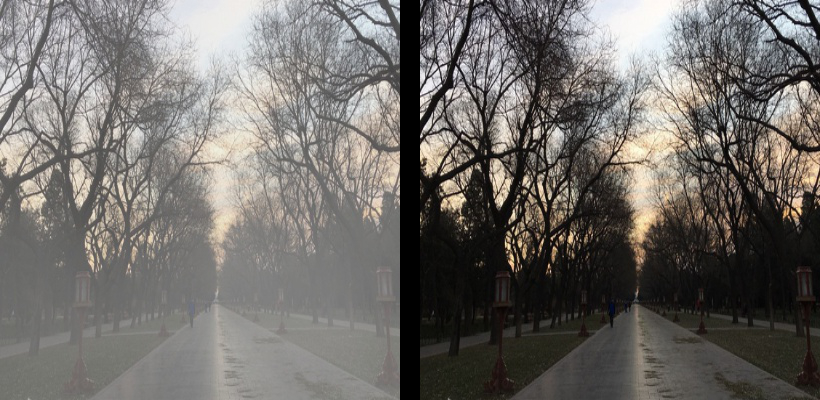

In [11]:
dataset.visualize_pair(dataset.index('1233.jpg'))
dataset.visualize_pair(dataset.index('1503.jpg'))

Input Image: Datasets/RESIDE-6K/train/hazy/166.jpg
Target Image: Datasets/RESIDE-6K/train/GT/166.jpg


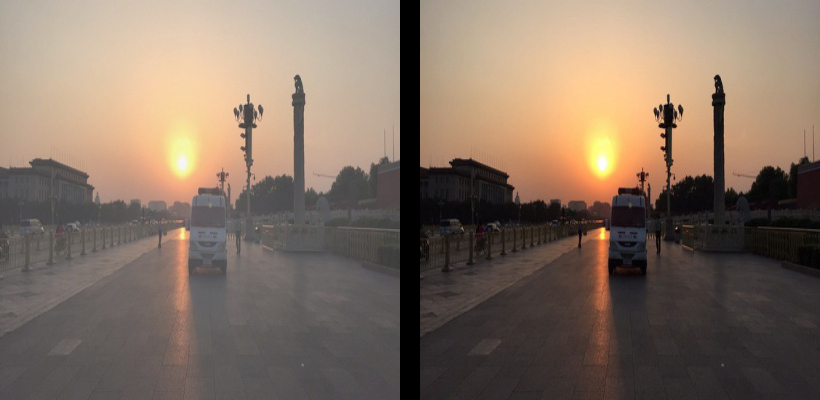

In [12]:
dataset.visualize_pair(734)

# dataset.index('407.jpg')

In [13]:
train_set, val_set = random_split(dataset, [5500, 500])

In [14]:
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
len(train_dataloader), len(val_dataloader)

(1375, 125)

In [16]:
class LightClearNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(128)

        # Decoder
        self.dec_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        skip1 = x
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        skip2 = x
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))

        # Decoder
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = x + skip2
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = x + skip1
        x = F.sigmoid(self.dec_conv3(x))

        return x

In [17]:
class LightClearNetAir(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(64)

        # Decoder
        self.dec_conv1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(32)
        self.dec_conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(16)
        self.dec_conv3 = nn.Conv2d(16, 3, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        skip1 = x
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        skip2 = x
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))

        # Decoder
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = x + skip2
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = x + skip1
        x = F.sigmoid(self.dec_conv3(x))

        return x

In [18]:
model = LightClearNet().to(device)

In [19]:
if USE_PARTIALLY_TRAINED:
    state_dict_loc = os.path.join(model_save_path, state_dict_name)
    state_dict = torch.load(state_dict_loc)
    model.load_state_dict(state_dict)

model.state_dict()

OrderedDict([('enc_conv1.weight',
              tensor([[[[ 1.2163e-01,  2.4168e-01,  3.6777e-01],
                        [-4.4133e-02,  1.1136e-01,  2.5392e-01],
                        [ 4.0324e-02, -1.7710e-02, -4.2801e-02]],
              
                       [[ 6.7190e-02,  1.4888e-01, -6.7532e-02],
                        [-1.6951e-01, -8.6637e-02,  2.5653e-03],
                        [-2.1832e-01,  9.7840e-02, -1.3944e-01]],
              
                       [[ 1.4477e-01,  1.8476e-01,  8.7768e-02],
                        [ 6.5965e-02,  4.2435e-02, -1.7154e-01],
                        [ 4.2382e-02, -6.6074e-02, -7.0377e-02]]],
              
              
                      [[[ 3.8996e-02,  1.7626e-01,  1.0218e-01],
                        [ 1.4237e-01, -2.4492e-01, -1.5689e-01],
                        [-1.2773e-01,  7.5083e-02,  1.5827e-01]],
              
                       [[ 3.9350e-02,  1.3898e-01,  4.3450e-02],
                        [ 1.0985e-01, -3.

In [20]:
model.eval()
with torch.inference_mode():
    pred = model(random.choice(dataset)[0].unsqueeze(0))
pred

tensor([[[[0.5556, 0.6736, 0.6780,  ..., 0.3727, 0.3127, 0.3754],
          [0.6584, 0.7247, 0.6769,  ..., 0.3130, 0.3668, 0.3375],
          [0.6968, 0.6567, 0.6368,  ..., 0.3586, 0.3100, 0.3424],
          ...,
          [0.2814, 0.2423, 0.2582,  ..., 0.3589, 0.3544, 0.3468],
          [0.2909, 0.2619, 0.2629,  ..., 0.3188, 0.3141, 0.3329],
          [0.3005, 0.2820, 0.2938,  ..., 0.3413, 0.2866, 0.3881]],

         [[0.6763, 0.6152, 0.6511,  ..., 0.3283, 0.2500, 0.3801],
          [0.6496, 0.6988, 0.6569,  ..., 0.2770, 0.2691, 0.3563],
          [0.7039, 0.6912, 0.6398,  ..., 0.2951, 0.2508, 0.3060],
          ...,
          [0.2434, 0.2062, 0.2211,  ..., 0.3048, 0.2995, 0.3143],
          [0.2597, 0.2198, 0.2308,  ..., 0.2828, 0.2678, 0.3217],
          [0.2372, 0.2324, 0.2621,  ..., 0.3189, 0.3051, 0.2887]],

         [[0.6675, 0.7154, 0.6557,  ..., 0.3702, 0.3046, 0.4072],
          [0.6536, 0.6817, 0.5955,  ..., 0.3068, 0.2904, 0.3921],
          [0.6993, 0.7212, 0.6250,  ..., 0

Datasets/RESIDE-6K/train/hazy/5863.jpg
Image size: [1, 3, 400, 400]
L1 Loss: 0.0801 | PSNR: 19.9601 | SSIM: 84.04%


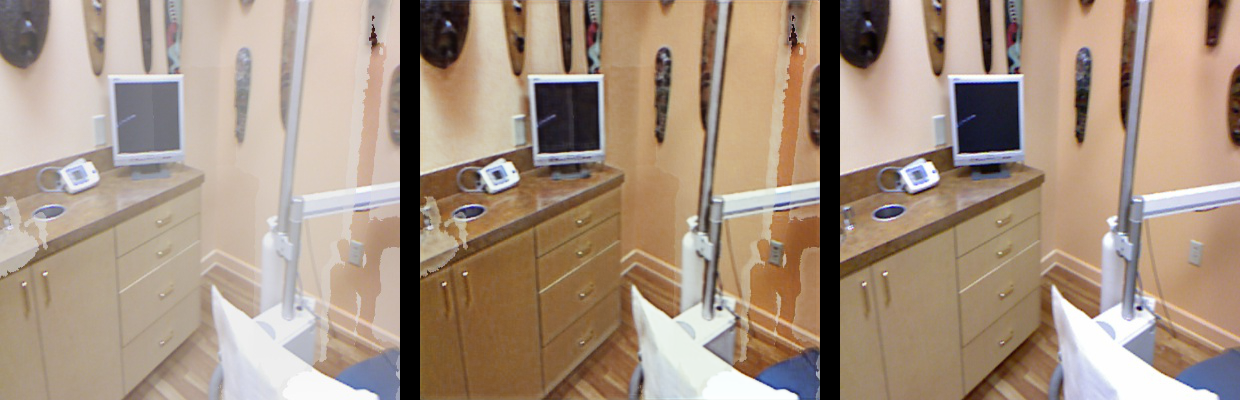

In [21]:
visualize_random_pair_pred(dataset, model, visualize_target=True)

In [22]:
criterion = nn.L1Loss()
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)

In [23]:
baseline_perf = (0, 0, 0)

In [24]:
if WANNA_TRAIN and baseline_perf == (0, 0, 0):
    loss = 0
    psnr = 0
    ssim = 0

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(val_dataloader):
            pred = model(X)

            loss += criterion(pred, y).item()
            psnr += psnr_metric(pred, y).item()
            ssim += ssim_metric(pred, y).item()

    loss /= len(val_dataloader)
    psnr /= len(val_dataloader)
    ssim /= len(val_dataloader)

    print(f'L1 Loss: {loss:.4f} | PSNR: {psnr:.4f} | SSIM: {ssim * 100:.2f}%')
    baseline_perf = (loss, psnr, ssim)

baseline_perf

(0, 0, 0)

In [25]:
train_losses = []
val_losses = []
psnrs = []
ssims = []

In [26]:
train_losses, val_losses, psnrs, ssims

([], [], [], [])

In [27]:
# %%timeit -n 1 -r 1

if WANNA_TRAIN:
    prev_size = len(train_losses)
    if INFER_DURING_TRAINING:
        if train_losses:
            new_folder = f'{infer_during_training_path}/{sorted(os.listdir(infer_during_training_path))[-1]}'
        else:
            new_folder = f'{infer_during_training_path}/pics_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_-_{model.__class__.__name__}'
        os.makedirs(new_folder, exist_ok=True)
        image_idx = 734
        infer_X = dataset[image_idx][0].unsqueeze(0)

    for epoch in tqdm(range(EPOCHS)):
        train_loss = 0
        val_loss = 0
        psnr = 0
        ssim = 0

        model.train()
        for X, y in tqdm(train_dataloader):
            pred = model(X) 
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.inference_mode():
            for X, y in tqdm(val_dataloader):
                pred = model(X)
                loss = criterion(pred, y)

                val_loss += loss.item()
                psnr += psnr_metric(pred, y).item()
                ssim += ssim_metric(pred, y).item()

        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        psnr /= len(val_dataloader)
        ssim /= len(val_dataloader)

        print(f'Epoch: {epoch + prev_size}/{EPOCHS + prev_size} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | PSNR: {psnr:.4f} | SSIM: {ssim:.4f}')
        
        if INFER_DURING_TRAINING:
            with torch.inference_mode():
                pred = model(infer_X)
            inferred_image = tensor_to_img(pred.squeeze())

            infer_pic_path = f'{new_folder}/{epoch + prev_size}.jpg'
            inferred_image.save(infer_pic_path)
            print(infer_pic_path)
                
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        psnrs.append(psnr)
        ssims.append(ssim)

In [28]:
if train_losses:
    plt.figure(figsize=(8, 10))
    plt.title(f'{model.__class__.__name__} Training/Validation Plot')
    plt.axis('off')

    # ========== (1) ==========

    plt.subplot(3, 1, 1)
    plt.plot([baseline_perf[0]] + train_losses, label='Train Loss')
    plt.plot([baseline_perf[0]] + val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.legend(loc='best')
    # plt.ylim(-0.05, 1)

    # ========== (2) ==========

    plt.subplot(3, 1, 2)
    plt.plot([baseline_perf[1]] + psnrs, label='PSNR', c='red')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.axvline(0, color='black')

    # ========== (3) ==========

    plt.subplot(3, 1, 3)
    plt.plot([baseline_perf[2]] + ssims, label='SSIM', c='green')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.axhline(1, color='black')
    plt.axvline(0, color='black')

    os.makedirs(plot_save_path, exist_ok=True)
    plot_file_name = f'{model.__class__.__name__}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.{"pdf" if SAVE_PLOT_AS_PDF else "png"}'
    plt.savefig(os.path.join(plot_save_path, plot_file_name), bbox_inches='tight')

    plt.show()

In [29]:
test_dataset = HazyToClearDataset(test_dataset_path, transform=img_to_tensor)

iset = set(test_dataset.inputs_file_list)
tset = set(test_dataset.targets_file_list)

print((iset - tset, tset - iset))

len(test_dataset), random.choice(test_dataset)

(set(), set())


(1000,
 (tensor([[[0.4431, 0.4275, 0.3569,  ..., 0.4863, 0.3216, 0.4510],
           [0.4000, 0.4118, 0.3804,  ..., 0.5059, 0.3490, 0.3569],
           [0.4157, 0.4392, 0.4431,  ..., 0.4902, 0.3647, 0.3412],
           ...,
           [0.2471, 0.2588, 0.2706,  ..., 0.2784, 0.2706, 0.2471],
           [0.3137, 0.2941, 0.2902,  ..., 0.2706, 0.2902, 0.2863],
           [0.3216, 0.2824, 0.2667,  ..., 0.2549, 0.2784, 0.2745]],
  
          [[0.4431, 0.4353, 0.3608,  ..., 0.4980, 0.3333, 0.4627],
           [0.3922, 0.4000, 0.3765,  ..., 0.5098, 0.3490, 0.3647],
           [0.3843, 0.4118, 0.4196,  ..., 0.4745, 0.3529, 0.3333],
           ...,
           [0.2667, 0.2784, 0.2941,  ..., 0.2980, 0.2941, 0.2706],
           [0.3333, 0.3137, 0.3137,  ..., 0.2941, 0.3137, 0.3098],
           [0.3412, 0.3020, 0.2902,  ..., 0.2784, 0.3020, 0.2980]],
  
          [[0.3490, 0.3490, 0.2902,  ..., 0.4314, 0.2902, 0.4196],
           [0.3098, 0.3255, 0.3059,  ..., 0.4549, 0.3098, 0.3216],
           [0.3

Index: 313
Input Image: Datasets/RESIDE-6K/test/hazy/0386_1_0.12.jpg
Target Image: Datasets/RESIDE-6K/test/GT/0386_1_0.12.jpg


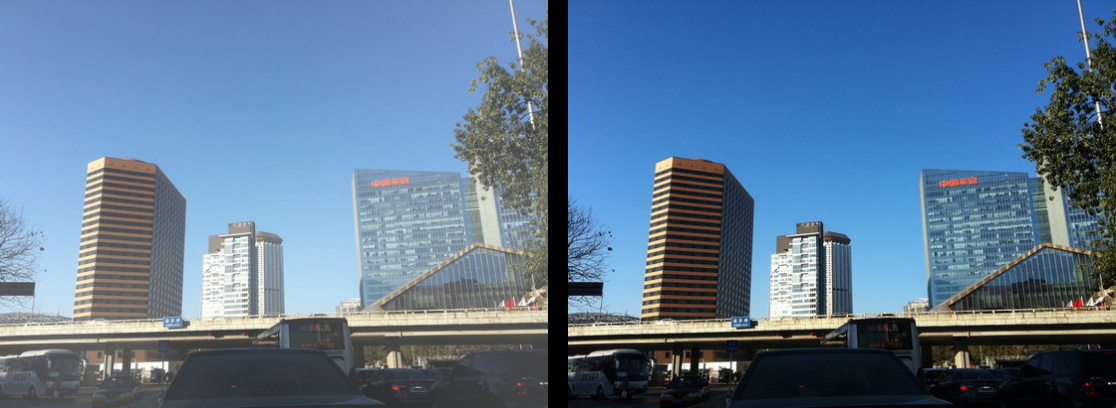

In [30]:
visualize_random_pair_target(test_dataset)

In [31]:
model.eval()
with torch.inference_mode():
    pred = model(random.choice(test_dataset)[0].unsqueeze(0))
pred

tensor([[[[0.4923, 0.5565, 0.5562,  ..., 0.6556, 0.6024, 0.6148],
          [0.5956, 0.6099, 0.5613,  ..., 0.6802, 0.7870, 0.6101],
          [0.6215, 0.5587, 0.5469,  ..., 0.6407, 0.6627, 0.6359],
          ...,
          [0.4161, 0.3789, 0.4329,  ..., 0.4214, 0.4035, 0.3812],
          [0.3917, 0.3739, 0.4010,  ..., 0.3864, 0.3921, 0.3713],
          [0.3466, 0.3432, 0.3859,  ..., 0.3812, 0.3382, 0.4195]],

         [[0.5684, 0.4565, 0.4546,  ..., 0.5326, 0.4581, 0.5554],
          [0.5226, 0.5262, 0.4695,  ..., 0.5458, 0.6086, 0.5741],
          [0.5700, 0.5343, 0.4559,  ..., 0.4897, 0.5100, 0.5026],
          ...,
          [0.3150, 0.2782, 0.2831,  ..., 0.2677, 0.2538, 0.2841],
          [0.2925, 0.2510, 0.2655,  ..., 0.2534, 0.2483, 0.2800],
          [0.2677, 0.2670, 0.2844,  ..., 0.2765, 0.2712, 0.2640]],

         [[0.4988, 0.4482, 0.3901,  ..., 0.4747, 0.4328, 0.5068],
          [0.4234, 0.3572, 0.3018,  ..., 0.4179, 0.5035, 0.5324],
          [0.4354, 0.3815, 0.3076,  ..., 0

In [32]:
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

len(test_dataloader)

1000

In [33]:
# %%timeit -n 1 -r 1

if WANNA_TEST:
    loss = 0
    psnr = 0
    ssim = 0

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader):
            preds = model(X)

            loss += criterion(preds, y).item()
            psnr += psnr_metric(preds, y).item()
            ssim += ssim_metric(preds, y).item()

    loss /= len(test_dataloader)
    psnr /= len(test_dataloader)
    ssim /= len(test_dataloader)

    result = f'L1 Loss: {loss:.4f} | PSNR: {psnr:.4f} | SSIM: {ssim * 100:.2f}%'
    print(result)

    os.makedirs(result_save_path, exist_ok=True)
    result_file_name = f'{model.__class__.__name__}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.txt'
    with open(os.path.join(result_save_path, result_file_name), 'w') as f:
        f.write(result)

Datasets/RESIDE-6K/test/hazy/1415_1.png
Image size: [1, 3, 460, 620]
L1 Loss: 0.0634 | PSNR: 21.7727 | SSIM: 87.78%


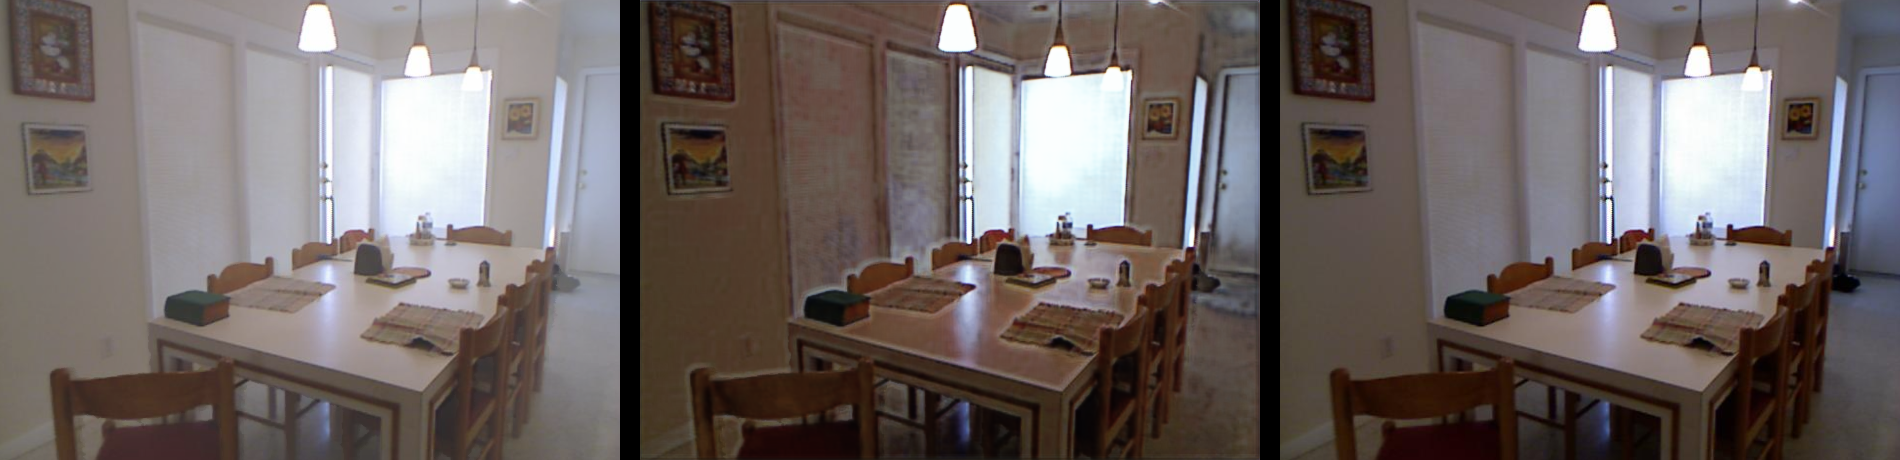

In [77]:
visualize_random_pair_pred(test_dataset, model, visualize_target=True)

In [35]:
if WANNA_SAVE:
    os.makedirs(model_save_path, exist_ok=True)
    model_name = f'{model.__class__.__name__}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pth'
    torch.save(model.state_dict(), os.path.join(model_save_path, model_name))